## MIE424 (2023 Winter) Lab 4

Presented by Arnaud Deza

  *  part 1)       Using JAX to calculate gradients for Gradient Descent
  *  part 2)       Visualizing Gradient Descent
  *  part 3)       Visualizing Project Gradient Descent
  *  part 4)       Comparison of computation cost for parenthesing matrix products
  *  part 5)       Gradient descent for non-convex functions

2 optional takehome exercises :)

# Import and Installations

In [ ]:
!pip install --upgrade pip
!pip install --upgrade "jax[cpu]"
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline
import scipy.optimize as opt
import scipy.linalg as la

## 1. Using JAX to calculate Gradients

This part of the lab will explain how to automatically calculate gradients that can then be used in many optimiazation algorithms, such as gradient descent.

  *  The hope is to give you a base to be able to implement algorithms manually.
  *  Visualizing these concepts makes life much easier.
  *  Get into the habit of trying things out! Machine learning is wonderful because it is so successful.

You can differentiate a function with `grad`:

In [ ]:
grad_tanh = grad(jnp.tanh)
print(grad_tanh(2.0))

0.070650816


`grad` takes a function and returns a function. If you have a Python function `f` that evaluates the mathematical function $f$, then `grad(f)` is a Python function that evaluates the mathematical function $\nabla f$. That means `grad(f)(x)` represents the value $\nabla f(x)$.

Since `grad` operates on functions, you can apply it to its own output to differentiate as many times as you like:


In [ ]:
print(grad(grad(jnp.tanh))(2.0))
print(grad(grad(grad(jnp.tanh)))(2.0))

-0.13621868
0.25265405


Let's know use JAX for GD for some datset

In [ ]:
# Step 1: Create data for gradient descent
key = random.PRNGKey(1)

data_points, data_dimension = 100, 2 

# Generate X and w, then set y = Xw + ϵ
X = random.normal(key, (data_points, data_dimension))

true_w = random.normal(key, (data_dimension,))
y = X.dot(true_w) + 0.1 * random.normal(key, (data_points,))

In [ ]:
# Step 2: Compute the linear algebra solution 
''' 
    - Given the data matrix X and the vector of labels y, compute the solution to ordinary least squares as shown in class
''' 
w_linalg =         np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)

Recall Gradient Descent algo from lecture

  *  Start with initial guess w^
  *  While ||$\nabla f(w^t)$|| > ϵ 
      *  $w^{t+1} = w^{t} - \alpha^{t} * ||\nabla f(w^t)$||

$\alpha^{t} > 0 $ : a step size or learning rate

$ \epsilon >= 0 $ : Convergence threshold (small constant)


In [ ]:
# Step 3: Use basic radient descent with 100 iterations and step size of 0.1 to find w_grad
step = 0.1
iterations = 100
w_grad = np.zeros(data_dimension)

def make_squared_error(X, y):
    def squared_error(w):
        return jnp.sum(jnp.power(X.dot(w) - y, 2)) / X.shape[0]
    return squared_error


# Now use jax grad
grad_loss = grad(make_squared_error(X, y))


for i in range(iterations):
    w_grad =    w_grad - step * grad_loss(w_grad)                             # INSERT CODE HERE

In [ ]:
print("\t w* retrieved with gradient descent: \t \t ",w_grad)
print("\t w* retrieved using algebraic solution to OLS: \t ",w_linalg)

	 w* retrieved with gradient descent: 	 	  [-0.12588218  2.2070653 ]
	 w* retrieved using algebraic solution to OLS: 	  [-0.125882  2.207066]


### Finite Difference Estimation

One way to estimate the gradient at a certain point is to take the "slope" at that point with a very small step in x.
Let's check if the grad of jax is accurate and makes sense numerically using finite differences.

In [ ]:
# Set a step size for finite differences calculations
eps = 1e-2
w = true_w

# Check W_grad with finite differences in a random direction
key, subkey = random.split(key)
vec = random.normal(subkey, w.shape)
unitvec = vec / jnp.sqrt(jnp.vdot(vec, vec))
w_grad_numerical = (make_squared_error(X, y)(w + eps / 2. * unitvec) - make_squared_error(X, y)(w - eps / 2. * unitvec)) / eps
print('w_grad_numerical', w_grad_numerical)
print('W_dirderiv_autodiff', jnp.vdot(grad(make_squared_error(X, y))(w), unitvec))

w_grad_numerical -0.019415654
W_dirderiv_autodiff -0.019415658


In [ ]:
for eps in np.logspace(-8,0,9):
    w_grad_numerical = (make_squared_error(X, y)(w + eps / 2. * unitvec) - make_squared_error(X, y)(w - eps / 2. * unitvec)) / eps
    print(f'Epsilon used: {eps}, directional derivative with FDM:  {w_grad_numerical}, difference with autodiff: {abs(w_grad_numerical-jnp.vdot(grad(make_squared_error(X, y))(w), unitvec))}')

Epsilon used: 1e-08, directional derivative with FDM:  -0.1862645149230957, difference with autodiff: 0.16684885323047638
Epsilon used: 1e-07, directional derivative with FDM:  0.0, difference with autodiff: 0.019415657967329025
Epsilon used: 1e-06, directional derivative with FDM:  -0.022351741790771484, difference with autodiff: 0.002936083823442459
Epsilon used: 1e-05, directional derivative with FDM:  -0.019371509552001953, difference with autodiff: 4.4148415327072144e-05
Epsilon used: 0.0001, directional derivative with FDM:  -0.019380822777748108, difference with autodiff: 3.483518958091736e-05
Epsilon used: 0.001, directional derivative with FDM:  -0.019416213035583496, difference with autodiff: 5.550682544708252e-07
Epsilon used: 0.01, directional derivative with FDM:  -0.019415654242038727, difference with autodiff: 3.725290298461914e-09
Epsilon used: 0.1, directional derivative with FDM:  -0.019415663555264473, difference with autodiff: 5.587935447692871e-09
Epsilon used: 1.0

# Part 2) Visualizing Gradient Descent

Now we are going to talk about visualizing each step in the gradient descent algorithm, starting with a one dimensional, and then continuing with a two dimensional data. We will be looking at how this affects both the data space (X vs Y) and the parameter space (w0 vs w1 vs Loss).

#### Visualization for 1 dimensional data

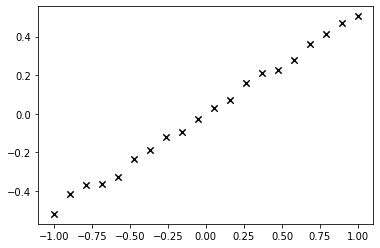

In [ ]:
# First consider the 1 dimensional data case.

# Create the data we want to fit
m = 20
theta1_true = 0.5
x = np.linspace(-1,1,m)
y = theta1_true * x + 0.02*np.random.randn(m)

# let's visualize it
plt.scatter(x, y, marker='x', s=40, color='k')
plt.show()

In [ ]:
# For the 1-D case implement the cost function for OLS and the linear hypothesis
#       - for the cost function use mean squared error (MSE)
#       - for the linear hypothesis, b = 0 in y=w^tx+b 

In [ ]:
def cost_func(theta1):
    """The cost function, J(theta1) describing the goodness of fit."""
    theta1 = np.atleast_2d(np.asarray(theta1))
    return np.average((y-hypothesis(x, theta1))**2, axis=1)/2

def hypothesis(x, theta1):
    """Our "hypothesis function", a straight line through the origin."""

    return  theta1*x # !!!       Insert code here            !!!!

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


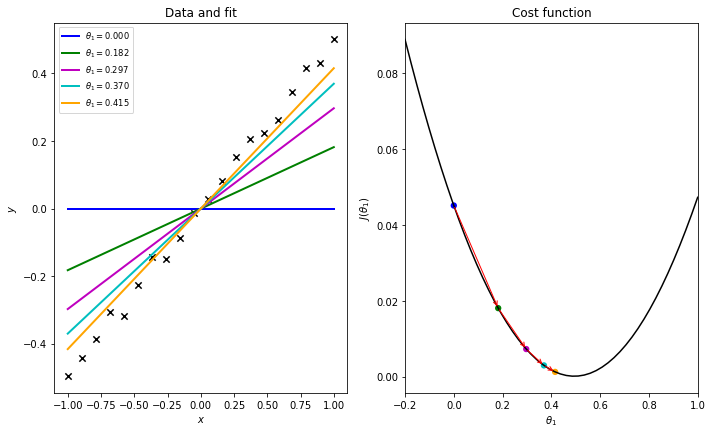

In [ ]:
# The plot: LHS is the data, RHS will be the cost function.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6.15))
ax[0].scatter(x, y, marker='x', s=40, color='k')

# First construct a grid of theta1 parameter pairs and their corresponding
# cost function values.
theta1_grid = np.linspace(-0.2,1,50)
J_grid = cost_func(theta1_grid[:,np.newaxis])

# The cost function as a function of its single parameter, theta1.
ax[1].plot(theta1_grid, J_grid, 'k')

# Take N steps with learning rate alpha down the steepest gradient,
# starting at theta1 = 0.
N = 5
alpha = 1
theta1 = [0]
J = [cost_func(theta1[0])[0]]
for j in range(N-1):
    last_theta1 = theta1[-1]
    this_theta1 = last_theta1 - alpha / m * np.sum( (hypothesis(x, last_theta1) - y) * x)
    theta1.append(this_theta1)
    J.append(cost_func(this_theta1))


# Annotate the cost function plot with coloured points indicating the
# parameters chosen and red arrows indicating the steps down the gradient.
# Also plot the fit function on the LHS data plot in a matching colour.
colors = ['b', 'g', 'm', 'c', 'orange']
ax[0].plot(x, hypothesis(x, theta1[0]), color=colors[0], lw=2,
           label=r'$\theta_1 = {:.3f}$'.format(theta1[0]))
for j in range(1,N):
    ax[1].annotate('', xy=(theta1[j], J[j]), xytext=(theta1[j-1], J[j-1]),
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')
    ax[0].plot(x, hypothesis(x, theta1[j]), color=colors[j], lw=2,
               label=r'$\theta_1 = {:.3f}$'.format(theta1[j]))

# Labels, titles and a legend.
ax[1].scatter(theta1, J, c=colors, s=40, lw=0)
ax[1].set_xlim(-0.2,1)
ax[1].set_xlabel(r'$\theta_1$')
ax[1].set_ylabel(r'$J(\theta_1)$')
ax[1].set_title('Cost function')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')
ax[0].set_title('Data and fit')
ax[0].legend(loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

#### Visualization for 2 dimensional data

In [ ]:
# The data to fit
m = 20
theta0_true = 2
theta1_true = 0.5
x = np.linspace(-1,1,m)
y = theta0_true + theta1_true * x + 0.02*np.random.randn(m)

In [ ]:
def cost_func(theta0, theta1):
    """The cost function, J(theta0, theta1) describing the goodness of fit."""
    theta0 = np.atleast_3d(np.asarray(theta0))
    theta1 = np.atleast_3d(np.asarray(theta1))
    return np.average((y-hypothesis(x, theta0, theta1))**2, axis=2)/2

def hypothesis(x, theta0, theta1):
    """Our "hypothesis function", a straight line."""
    return theta0 + theta1*x

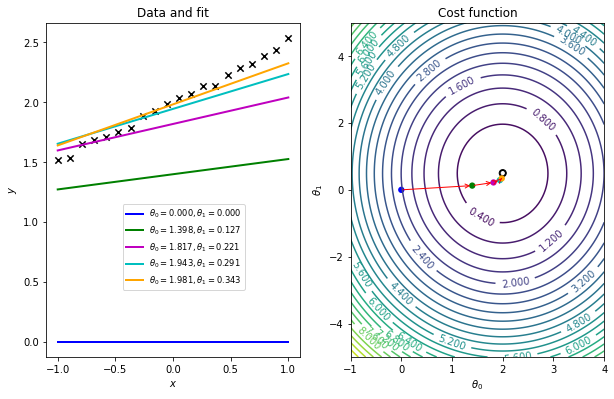

In [ ]:
# The plot: LHS is the data, RHS will be the cost function.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6.15))
ax[0].scatter(x, y, marker='x', s=40, color='k')

# First construct a grid of (theta0, theta1) parameter pairs and their
# corresponding cost function values.
theta0_grid = np.linspace(-1,4,101)
theta1_grid = np.linspace(-5,5,101)
J_grid = cost_func(theta0_grid[np.newaxis,:,np.newaxis],
                   theta1_grid[:,np.newaxis,np.newaxis])

# A labeled contour plot for the RHS cost function
X, Y = np.meshgrid(theta0_grid, theta1_grid)
contours = ax[1].contour(X, Y, J_grid, 30)
ax[1].clabel(contours)
# The target parameter values indicated on the cost function contour plot
ax[1].scatter([theta0_true]*2,[theta1_true]*2,s=[50,10], color=['k','w'])


# Take N steps with learning rate alpha down the steepest gradient,
# starting at (theta0, theta1) = (0, 0).
N = 5
alpha = 0.7
theta = [np.array((0,0))]
J = [cost_func(*theta[0])[0]]
for j in range(N-1):
    last_theta = theta[-1]
    this_theta = np.empty((2,))
    this_theta[0] = last_theta[0] - alpha / m * np.sum(
                                    (hypothesis(x, *last_theta) - y))
    this_theta[1] = last_theta[1] - alpha / m * np.sum(
                                    (hypothesis(x, *last_theta) - y) * x)
    theta.append(this_theta)
    J.append(cost_func(*this_theta))



# Annotate the cost function plot with coloured points indicating the
# parameters chosen and red arrows indicating the steps down the gradient.
# Also plot the fit function on the LHS data plot in a matching colour.
colors = ['b', 'g', 'm', 'c', 'orange']
ax[0].plot(x, hypothesis(x, *theta[0]), color=colors[0], lw=2,
           label=r'$\theta_0 = {:.3f}, \theta_1 = {:.3f}$'.format(*theta[0]))
for j in range(1,N):
    ax[1].annotate('', xy=theta[j], xytext=theta[j-1],
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')
    ax[0].plot(x, hypothesis(x, *theta[j]), color=colors[j], lw=2,
           label=r'$\theta_0 = {:.3f}, \theta_1 = {:.3f}$'.format(*theta[j]))
ax[1].scatter(*zip(*theta), c=colors, s=40, lw=0)

# Labels, titles and a legend.
ax[1].set_xlabel(r'$\theta_0$')
ax[1].set_ylabel(r'$\theta_1$')
ax[1].set_title('Cost function')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')
ax[0].set_title('Data and fit')
axbox = ax[0].get_position()
# Position the legend by hand so that it doesn't cover up any of the lines.
ax[0].legend(loc=(axbox.x0+0.5*axbox.width, axbox.y0+0.1*axbox.height),
             fontsize='small')

plt.show()

# Part 3)       Visualizing Project Gradient Descent

In [ ]:
def generate_data(num_samples, num_features, num_nonneg, nonneg_value, noise):
    # Making sure that a projection is acctually needed for this dataset
    beta_star = np.random.randn(num_features)-5
    beta_star[0:num_nonneg] = nonneg_value
    X = 10*np.random.randn(num_samples, num_features)
    Y = np.matmul(X,beta_star)+noise*np.random.randn(num_samples)
    return X, Y, beta_star

In [ ]:
def nonneg_project(u, S):
    # Projection onto feasible set
    v = ...
    return v

def loss(beta):
    # MSE loss
    return ...

def nonneg_OLS(X, Y, S, max_iter):
    beta, betas = ..., ...
    # beta is the optimal solution returned at convergence
    # betas is a list of the beta found at every iteration
    return beta, betas

def OLS(X, Y, max_iter):
    beta, betas = ..., ...
    # beta is the optimal solution returned at convergence
    # betas is a list of the beta found at every iteration
    return beta, betas

In [ ]:
def nonneg_project(u, S):
    v = np.array(u)
    uS = v[S]
    uS[uS<0] = 0
    v[S] = uS
    return v

def loss(beta):
    # MSE loss
    return np.sum((Y.reshape((Y.shape[0],1))-X.dot(beta))**2,axis=0)/2

def nonneg_OLS(X, Y, S, max_iter):
    n, d = X.shape
    w, v = np.linalg.eig(np.matmul(np.transpose(X),X))
    L    = np.max(w)
    betas= np.zeros((max_iter+1,d))

    XTX  = np.matmul(np.transpose(X),X)
    XTY  = np.matmul(np.transpose(X),Y)
        
    beta = np.zeros(d)
    betas[0,:] = beta
    for i in range(max_iter):
        beta         = nonneg_project(beta-(1/L)*(np.matmul(XTX, beta) - XTY), S)
        betas[i+1,:] = beta
    return beta, betas

def OLS(X, Y, max_iter):
    n, d = X.shape
    w, v = np.linalg.eig(np.matmul(np.transpose(X),X))
    L    = np.max(w)
    betas= np.zeros((max_iter+1,d))

    XTX  = np.matmul(np.transpose(X),X)
    XTY  = np.matmul(np.transpose(X),Y)
        
    beta = np.zeros(d)
    betas[0,:] = beta
    for i in range(max_iter):
        beta         = beta-(1/L)*(np.matmul(XTX, beta) - XTY)
        betas[i+1,:] = beta
    return beta, betas

In [ ]:
# use the np.random.seed to fix the generated data
np.random.seed(424)
# generate a dataset of 100 samples with 2 features each
X, Y, beta_star = generate_data(100,2,1,0.05,100)

In [ ]:
beta_hat, betas = nonneg_OLS(X,Y,np.arange(1),10)

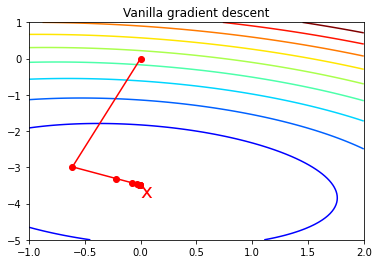

In [ ]:
beta_hat, betas = OLS(X,Y,10)
x = np.linspace(-1, 2, 100)
y = np.linspace(-5, 1, 100)
X_plot, Y_plot = np.meshgrid(x, y)
Z = loss(np.vstack([X_plot.ravel(), Y_plot.ravel()])).reshape((100,100))
Zmin = np.min(Z)
Zmax = np.max(Z)
plt.contour(X_plot, Y_plot, Z, np.arange(10)/10*(Zmax-Zmin)+Zmin, cmap='jet')
plt.text(beta_star[0], beta_star[1], 'x', va='center', ha='center', color='red', fontsize=20)
plt.plot(betas[:, 0], betas[:, 1], 'o-', c='red')
plt.title('Vanilla gradient descent')
pass

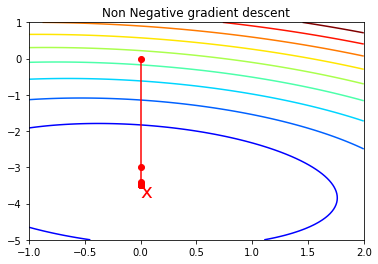

In [ ]:
beta_hat, betas = nonneg_OLS(X,Y,np.arange(1),10)
x = np.linspace(-1, 2, 100)
y = np.linspace(-5, 1, 100)
X_plot, Y_plot = np.meshgrid(x, y)
Z = loss(np.vstack([X_plot.ravel(), Y_plot.ravel()])).reshape((100,100))
Zmin = np.min(Z)
Zmax = np.max(Z)
# Plotting the contour's of the objective value for specific beta
plt.contour(X_plot, Y_plot, Z, np.arange(10)/10*(Zmax-Zmin)+Zmin, cmap='jet')
# plot the true optimum
plt.text(beta_star[0], beta_star[1], 'x', va='center', ha='center', color='red', fontsize=20)
# plot beta for every iteration
plt.plot(betas[:, 0], betas[:, 1], 'o-', c='red')
plt.title('Non Negative gradient descent')
pass



# Part 4) Comparing computation cost of parenthesizing matrix products 

In this section, we experiment with the computation cost of calculating $X^TXw$, where $X$ is a $n\times d$ matrix, $w$ is a $d\times1$ vector.

As discussed in the lecture, there are two ways that one can compute the product:

  *  Method 1: $(X^TX)w$ by first computing $A = X^TX$, then compute $Aw$.

  *  Method 2: $X^T(Xw)$ by first computing $b = Xw$, then compute $X^Tb$.

#### First, generate $X$ and $w$ using `np.random.randn`:

In [ ]:
def generate_data(n=int(1e4),d=int(5e3)):
    X = np.random.randn(n,d)
    w = np.random.randn(d,1)
    return X, w

# use the np.random.seed to fix the generated data
np.random.seed(4242022)
X, w = generate_data()

This would be a relatively large dataset:

In [ ]:
print(f"Memory size of X is about: {X.nbytes/(1024)**2} MB.")

Memory size of X is about: 381.4697265625 MB.


**Exercise:** 

Complete the following function `computation1`, `computation2` to implement the two methods above.

In [ ]:
def computation1 (X, w):
    #### FILL IN ####
    return np.matmul(np.matmul(np.transpose(X), X),w)

In [ ]:
def computation2 (X, w):
    #### FILL IN ####
    return np.matmul(np.transpose(X),X.dot(w))

Sanity check: if the results returned from the two methods above are the same.

In [ ]:
def check_consistent_results (X, w, method1, method2):
    
    result1 = computation1(X, w)
    result2 = computation2(X, w)
    
    return bool(np.product(result1==result2))

In [ ]:
check_consistent_results (X, w, computation1, computation2)

False

Does this mean our codes are not correct? Let's evaluate the actual difference:


In [ ]:
def check_results_difference (X, w, method1, method2):
    
    result1 = computation1(X, w)
    result2 = computation2(X, w)
    
    return np.linalg.norm(result1-result2)

In [ ]:
check_results_difference (X, w, computation1, computation2)

1.505224415364256e-09

FYI: Numpy has an inbuilt function that allows comparison up to a certain tolerance

In [ ]:
result1 = computation1(X, w)
result2 = computation2(X, w)
print(np.isclose(result1,result2,1e-12))

np.isclose(result1,result2,1e-12).all()

[[ True]
 [ True]
 [ True]
 ...
 [ True]
 [ True]
 [ True]]


True

Now let's evaluate the computational cost of these two different approaches:


In [ ]:
def timing_computation(X, w, method):
    tic = time.time()
    method(X,w)
    duration = time.time() - tic
    print(f"Computation time cost: {duration} seconds.")
    return duration

In [ ]:
time1 = timing_computation(X, w, computation1)
time2 = timing_computation(X, w, computation2)
print(f"Method 2 is {time1/time2-1} times faster than method 1.")

Computation time cost: 7.432159423828125 seconds.
Computation time cost: 0.03637123107910156 seconds.
Method 2 is 203.34170643452725 times faster than method 1.


# Part 5) Gradient Descent with Non-convex Functions

In this section, we apply gradient descent method trying to minimize the following function:

$f(x)=100(x_2-x_1^2)^2+(1-x_1)^2$

This function is a special case of rosenbrock (banana) function.

In [ ]:
def rosen(x):
    """
    The Rosenbrock function.
    The function computed is::
        sum(100.0*(x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)
        
    Parameters
    x : array of points at which the Rosenbrock function is to be computed.
    
    Returns
    r : float. The value of the Rosenbrock function.
    """
    r = np.sum(100.0 * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0,axis=0)
    return r

In [ ]:
def rosen_grad(x):
    """
    The derivative (i.e. gradient) of the Rosenbrock function.
    
    Parameters
    x : array of points at which the derivative is to be computed.
        
    Returns
    rosen_grad : (N,) ndarray
        The gradient of the Rosenbrock function at `x`.
    """
    grad_x1 = -400*x[0]*(x[1]-x[0]**2) + 2*(x[0]-1)  
    grad_x2 = 200*(x[1]-x[0]**2)
    return np.array([grad_x1,grad_x2])

Check if your implementation is correct:

In [ ]:
# use the np.random.seed to fix the generated data
np.random.seed(4242021)
for x in np.random.uniform(-2,2,(10,2)):
    print(x, opt.check_grad(rosen, rosen_grad, x))

# Scipy check_grad: Check the correctness of a gradient function by comparing it against a (forward) finite-difference approximation of the gradient.
# Return's err: The square root of the sum of squares (i.e., the 2-norm) of the difference between grad(x0, *args) and the finite difference approximation of grad using func at the points x0.

[ 1.31543792 -0.68565015] 1.969560366416445e-05
[1.99018777 0.18375398] 1.4238076578208733e-05
[-1.27145898 -0.24309171] 1.1263845782488468e-05
[-0.14347088  1.14465326] 5.67235313979217e-06
[-0.25509439 -0.49192335] 2.2040748184545294e-06
[-0.01927951  1.21339502] 5.101649720777197e-06
[-0.36440224  0.78641842] 2.240756078107898e-06
[-0.01521241 -1.1745241 ] 1.8122945855386832e-06
[-1.99183942 -1.46266443] 1.4642754998152777e-05
[-1.13488167  0.92250244] 9.024082546875058e-06


**Question:** 

What's the global minimum for the function $f(x)=100(x_2-x_1^2)^2+(1-x_1)^2$?

In [ ]:
x_star = np.array([1,1])

In [ ]:
rosen(x_star)

0.0

In [ ]:
rosen_grad(x_star)

array([0, 0])

Visualize $f(x)$ by contour.

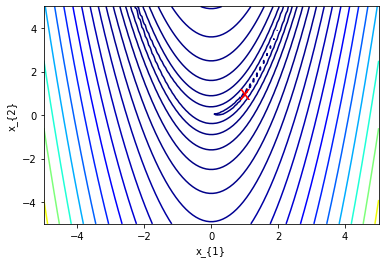

In [ ]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(20)**4, cmap='jet')
plt.text(x_star[0], x_star[1], 'x', va='center', ha='center', color='red', fontsize=20)
plt.xlabel('x_{1}')
plt.ylabel('x_{2}')
pass

Zooming in to the global minimum `x_star`

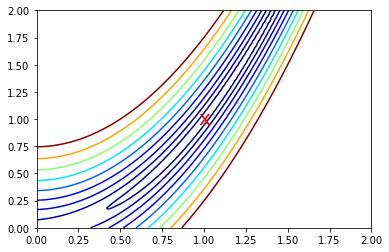

In [ ]:
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, [rosen(np.array([k, k])) for k in np.linspace(1, 1.5, 10)], cmap='jet')
plt.text(x_star[0], x_star[1], 'x', va='center', ha='center', color='red', fontsize=20)
pass

**Exercise:** 

Complete the update rule in the gradient descent funciton `gd()`.

In [ ]:
def gd(x, grad, alpha, max_iter=10):
    # starting intialization
    # gradient of function
    # step size or learning rate
    # max number of iterations
    xs = np.zeros((1 + max_iter, x.shape[0]))
    xs[0,:] = x
    for i in range(max_iter):
        x = x - alpha * grad(x)
        xs[i+1,:] = x
    return xs

In [ ]:
alpha = 0.0002
x0 = np.array([4,-4])
xs = gd(x0, rosen_grad, alpha, max_iter=100)

Let's visualize the iterates of the gradient descent.

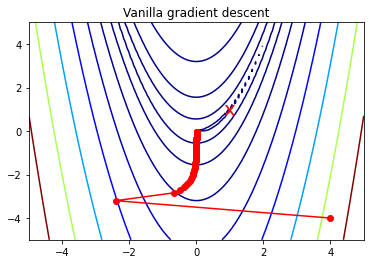

In [ ]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20)
plt.plot(xs[:, 0], xs[:, 1], 'o-', c='red')
plt.title('Vanilla gradient descent')
pass

In [ ]:
x0=xs[-1,:]
x0

array([ 0.01775411, -0.05095486])

Iterations: 1000
Iterations: 2000
Iterations: 3000
Iterations: 4000
Iterations: 5000
Iterations: 6000
Iterations: 7000
Iterations: 8000
Iterations: 9000
Iterations: 10000


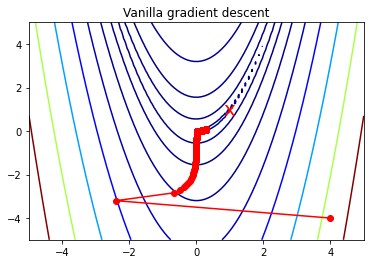

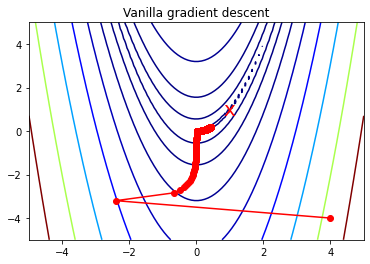

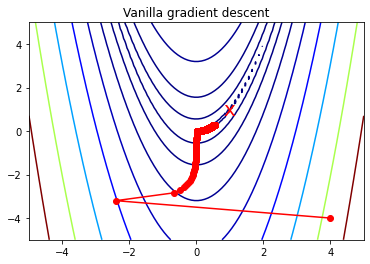

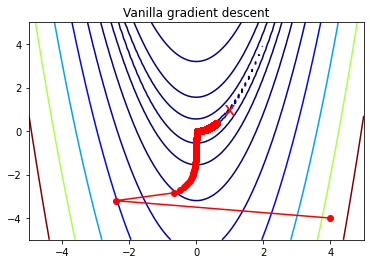

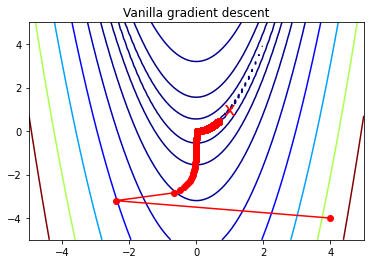

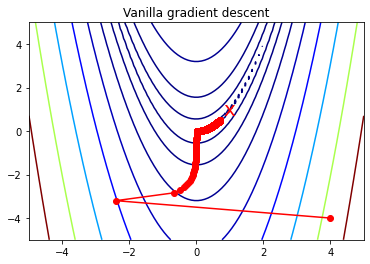

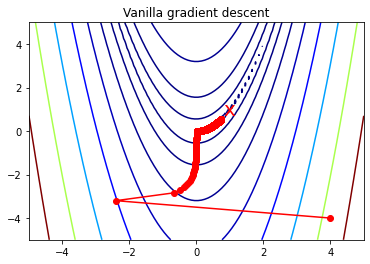

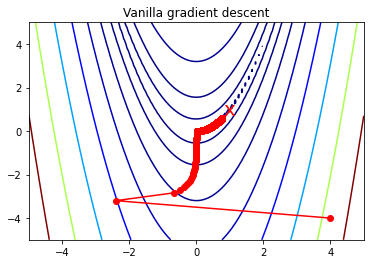

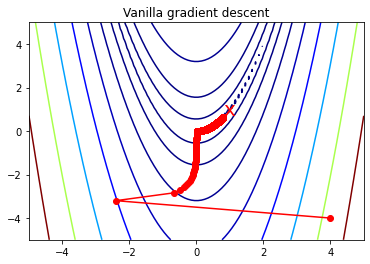

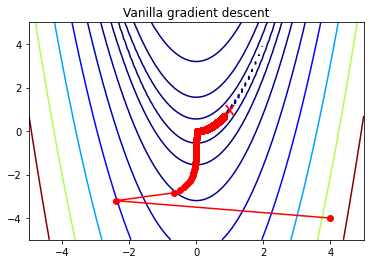

In [ ]:
alpha = 0.0002
x0 = np.array([4,-4])
for i in range(10):
    print(f'Iterations: {1000+i*1000}')
    plt.figure(i)
    xs = gd(x0, rosen_grad, alpha, max_iter=1000*(1+i))
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
    plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
    plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20)
    plt.plot(xs[:, 0], xs[:, 1], 'o-', c='red')
    plt.title('Vanilla gradient descent')
    #pass

Now let's consider increasing the stepsize:


In [ ]:
alpha = 0.0003
x0 = np.array([4,-4])
xs = gd(x0, rosen_grad, alpha, max_iter=10)
xs

<ipython-input-30-1d72cd2e74a3>:12: RuntimeWarning: overflow encountered in double_scalars
  grad_x1 = -400*x[0]*(x[1]-x[0]**2) + 2*(x[0]-1)
<ipython-input-30-1d72cd2e74a3>:13: RuntimeWarning: overflow encountered in double_scalars
  grad_x2 = 200*(x[1]-x[0]**2)
<ipython-input-30-1d72cd2e74a3>:12: RuntimeWarning: invalid value encountered in double_scalars
  grad_x1 = -400*x[0]*(x[1]-x[0]**2) + 2*(x[0]-1)
<ipython-input-30-1d72cd2e74a3>:13: RuntimeWarning: invalid value encountered in double_scalars
  grad_x2 = 200*(x[1]-x[0]**2)


array([[ 4.00000000e+000, -4.00000000e+000],
       [-5.60180000e+000, -2.80000000e+000],
       [ 1.73786137e+001, -7.49190206e-001],
       [-6.14028373e+002,  1.74167340e+001],
       [ 2.77790192e+007,  2.26382223e+004],
       [-2.57236132e+021,  4.63004346e+013],
       [ 2.04257099e+063,  3.97022567e+041],
       [-1.02261634e+189,  2.50325776e+125],
       [             inf,              inf],
       [             nan,              nan],
       [             nan,              nan]])

### Wow, what happend? 

gradient descent is taking successive steps in the direction of the minimum. If the step size is too large, it can (plausibly) "jump over" the minima we are trying to reach, ie. we overshoot. This can lead to osculations around the minimum or in some cases to outright divergence. 

What about adapatively increase the stepsize? For example, $\alpha=\alpha_0 \sqrt{k}$ for the $k$th iterate.

In [ ]:
def adaptive_gd(x, grad, alpha, max_iter=10):
    xs = np.zeros((1 + max_iter, x.shape[0]))
    xs[0,:] = x
    for i in range(max_iter):
        x = x - alpha*i**0.5 * grad(x)
        xs[i+1,:] = x
    return xs

[0.83120453 0.68990336]


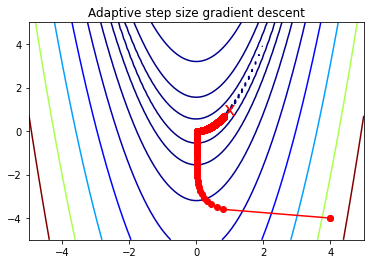

In [ ]:
alpha = 0.0001
x0 = np.array([4,-4])
xs = adaptive_gd(x0, rosen_grad, alpha, max_iter=1000)

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20)
plt.plot(xs[:, 0], xs[:, 1], 'o-', c='red')
plt.title('Adaptive step size gradient descent')
print(xs[-1,:])

Using `scipy.optimize` to implement gradient descent and visualize the change of function value and norm of gradient.

In [ ]:
def custmin(fun, x0, args=(), maxfev=None, alpha=0.0002,
        maxiter=100000, tol=1e-10, callback=None, **options):
    """Implements simple gradient descent for the Rosen function."""
    bestx = x0
    bestf = fun(x0)
    funcalls = 1
    niter = 0
    improved = True
    stop = False

    while improved and not stop and niter < maxiter:
        niter += 1
        # the next 2 lines are gradient descent
        step = alpha * rosen_grad(bestx)
        bestx = bestx - step

        bestf = fun(bestx)
        funcalls += 1

        if la.norm(step) < tol:
            improved = False
        if callback is not None:
            callback(bestx)
        if maxfev is not None and funcalls >= maxfev:
            stop = True
            break

    return opt.OptimizeResult(fun=bestf, x=bestx, nit=niter,
                              nfev=funcalls, success=(niter > 1))
def reporter(p):
    """Reporter function to capture intermediate states of optimization."""
    global ps
    ps.append(p)

In [ ]:
x0 = np.array([4,-4.1])
ps = [x0]
opt.minimize(rosen, x0, method=custmin, callback=reporter)

     fun: 1.060466347344834e-08
    nfev: 100001
     nit: 100000
 success: True
       x: array([0.9998971 , 0.99979381])

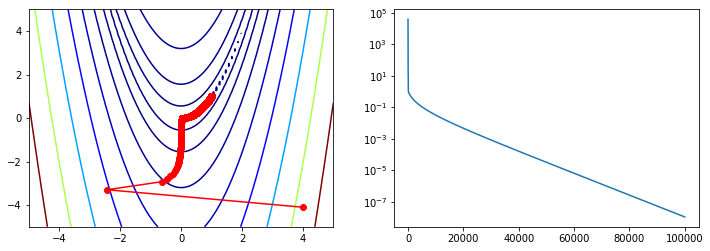

In [ ]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T))
pass

Now let's take a closer look at this type of function:
$$f_a(x)=a(x_2-x_1^2)^2+(1-x_1)^2$$

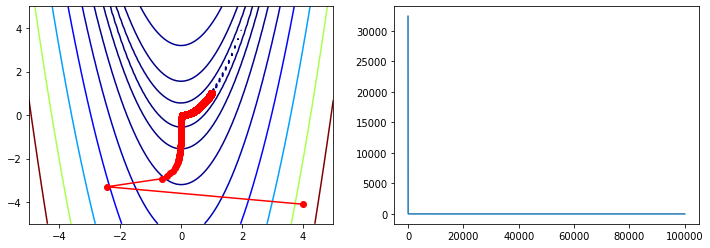

In [ ]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.plot(range(len(ps)), np.sqrt(np.sum(rosen_grad(ps.T)**2,axis=0)))
pass

Different functions beheave differently when applying GD to them

The convergence of gradient descemnt for a given function is related to the "conditioning" of the hessian of said function

More specifically, The condition number of an invertible square matrix A is the ratio between its largest and smallest singular values. 

When the condition number is:
  *  if ~ 1, the matrix is well conditioned GD will probably work just fine
  *  if >> 1, the matrix is ill-conditioned and can lead to numerical issues

In [ ]:
def rosen_hess(x):
    H=np.zeros((2,2), dtype=x.dtype)
    H[0,0] = 1200*x[0]**2 -400*x[1]+2
    H[0,1] = -400*x[0]
    H[1,0] = -400*x[0]
    H[1,1] = 200
    return H

In [ ]:
H = rosen_hess(x_star)
np.linalg.cond(H)

2508.009601277298

**Take-home Exercise**:

1. Use gradient descent for minimizing $f_a(x)$ for $a=10,1,0.1,0.01$. Compute the condition number of the Hessian of $f_a(x)$.

2. Use JAX (we've seen in Lab 4) to implement the experiment (third section) and complete the above question.

# References

Code was used from the following sources:

https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/autodiff_cookbook.ipynb#scrollTo=R8q5RiY3l7Fw

https://scipython.com/blog/visualizing-the-gradient-descent-method/

https://colindcarroll.com/2019/04/06/exercises-in-automatic-differentiation-using-autograd-and-jax/